In [19]:
import torch
import matplotlib.pyplot as plt

from kan import *
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import time
from scipy import special
from kan import feynman
import torch.nn as nn
from torch.nn import functional as F



In [20]:
pi = torch.pi
# sec 3.1 toy datasets

f1 = lambda x: special.jn(0, 20*x[:,0])  
f2 = lambda x: torch.exp(x[:,1]**2  + torch.sin(x[:,0]*pi))
f3 = lambda x: x[:,0]*x[:,1]
f4 = lambda x: torch.exp(
    0.01 * torch.sum(torch.stack([
        (torch.sin(0.5 * pi * x[:, i]))**2 for i in range(100)
    ], dim=0), dim=0)
).reshape(-1, 1)
f5 = lambda x: torch.exp(0.5*(torch.sin(pi*(x[:,0]**2 + x[:,1]**2))+torch.sin(pi*(x[:,2]**2 + x[:,3]**2))))

## Feynman datasets (dimensionless formula)
# 
f6 = lambda x: x[:,0]*(1/x[:,1] - 1) # used [2, 2, 1]
f7 = lambda x: 1 + x[:,0]*torch.sin(pi*x[:,1]) # used [2, 2, 2, 1]
f8 = lambda x: x[:,0]*torch.exp(-x[:,1]) # used [2, 1, 1]
# f9 = x/y
f9 = lambda x: x[:,0] / (x[:,1] + 1e-5) # used [2, 1, 1]
# f10 = (1+a**2+b**2)**0.5
f10 = lambda x: torch.sqrt(1 + x[:,0]**2 + x[:,1]**2) # used [2, 1, 1]



In [21]:

class MLP(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, output_dim=1):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, hidden_dim//4),
            nn.ReLU(),
            nn.Linear(hidden_dim//4, output_dim)
        )

    def forward(self, x):
        return self.model(x)



class MLP_2(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, output_dim=1):
        super(MLP_2, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, output_dim)
        )

    def forward(self, x):
        return self.model(x)
    
class MLP_4(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, output_dim=1):
        super(MLP_4, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, hidden_dim//4),
            nn.ReLU(),
            nn.Linear(hidden_dim//4, hidden_dim//4),
            nn.ReLU(),
            nn.Linear(hidden_dim//4, output_dim)
        )

    def forward(self, x):
        return self.model(x)
    
   


In [22]:
mlp_param_list = []
mlp_mse_list = []

kan_param_list = []
kan_mse_list = []

kan_train_time = []
mlp_train_time = []

hidden_sizes = [64, 128, 256, 512]
widths_list = [[100,1,1], [100,2,1], [100,4,1],[100,8,1],[100,16,1],[100,32,1]]
dataset = create_dataset(f4, n_var=100, ranges=[-1, 1]) #change f1 to other function names for testing on desired function for graphs

x_train = dataset['train_input']
y_train = dataset['train_label']
x_test = dataset['test_input']
y_test = dataset['test_label']

train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=128)

for h in hidden_sizes:
    # === MLP ===
    mlp_model = MLP(input_dim=100, hidden_dim=h, output_dim=1)
    optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    start = time.time()
    for epoch in range(50):
        mlp_model.train()
        for xb, yb in train_loader:
            pred = mlp_model(xb)
            loss = loss_fn(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    end = time.time()

    with torch.no_grad():
        mlp_pred = mlp_model(x_test)
        mlp_mse = F.mse_loss(mlp_pred, y_test).item()

    count= 0
    for p in mlp_model.parameters():
      if p.requires_grad:
        p_count = p.numel()
        count += p_count
    mlp_param_list.append(count)
    mlp_mse_list.append(mlp_mse)
    mlp_train_time.append(end-start)

for width in widths_list:
    # === KAN ===
    kan_model = KAN(width=width)
    start = time.time()
    kan_model.fit(dataset, steps=50)
    end = time.time()

    with torch.no_grad():
        kan_pred = kan_model(x_test)
        kan_mse = F.mse_loss(kan_pred, y_test).item()

    count = 0
    for p in kan_model.parameters():
        if p.requires_grad:
            p_count = p.numel()
            count += p_count
    kan_param_list.append(count)
    kan_mse_list.append(kan_mse)
    kan_train_time.append(end-start)
    




checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.66e-03 | test_loss: 3.35e-03 | reg: 7.22e+00 | : 100%|█| 50/50 [00:06<00:00,  7.63it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.73e-03 | test_loss: 9.53e-03 | reg: 1.66e+01 | : 100%|█| 50/50 [00:08<00:00,  5.90it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.20e-03 | test_loss: 1.50e-02 | reg: 2.25e+01 | : 100%|█| 50/50 [00:08<00:00,  5.65it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.00e-06 | test_loss: 7.76e-02 | reg: 3.82e+01 | : 100%|█| 50/50 [00:11<00:00,  4.28it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.42e-07 | test_loss: 1.05e-01 | reg: 6.28e+01 | : 100%|█| 50/50 [00:13<00:00,  3.77it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.62e-07 | test_loss: 8.16e-02 | reg: 1.00e+02 | : 100%|█| 50/50 [00:19<00:00,  2.51it

saving model version 0.1


In [23]:
mlp_param_list_2 = []
mlp_mse_list_2 = []
mlp_train_time_2 = []

mlp_param_list_4 = []
mlp_mse_list_4 = []
mlp_train_time_4 = []

for h in hidden_sizes:
 
    # === MLP ===
    mlp_model = MLP_2(input_dim=100, hidden_dim=h, output_dim=1)
    optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()
    start = time.time()
    for epoch in range(50):
        mlp_model.train()
        for xb, yb in train_loader:
            pred = mlp_model(xb)
            loss = loss_fn(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    end = time.time()
    with torch.no_grad():
        mlp_pred = mlp_model(x_test)
        mlp_mse = F.mse_loss(mlp_pred, y_test).item()
    count = 0
    for p in mlp_model.parameters():
      if p.requires_grad:
        p_count = p.numel()
        count += p_count
    mlp_param_list_2.append(count)
    mlp_mse_list_2.append(mlp_mse)
    mlp_train_time_2.append(end-start)
    # === MLP ===
    mlp_model = MLP_4(input_dim=100, hidden_dim=h, output_dim=1)
    optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()
    start = time.time()
    for epoch in range(50):
        mlp_model.train()
        for xb, yb in train_loader:
            pred = mlp_model(xb)
            loss = loss_fn(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    end = time.time()
    with torch.no_grad():
        mlp_pred = mlp_model(x_test)
        mlp_mse = F.mse_loss(mlp_pred, y_test).item()
    count = 0
    for p in mlp_model.parameters():
      if p.requires_grad:
        p_count = p.numel()
        count += p_count
    mlp_param_list_4.append(count)
    mlp_mse_list_4.append(mlp_mse)
    mlp_train_time_4.append(end-start)


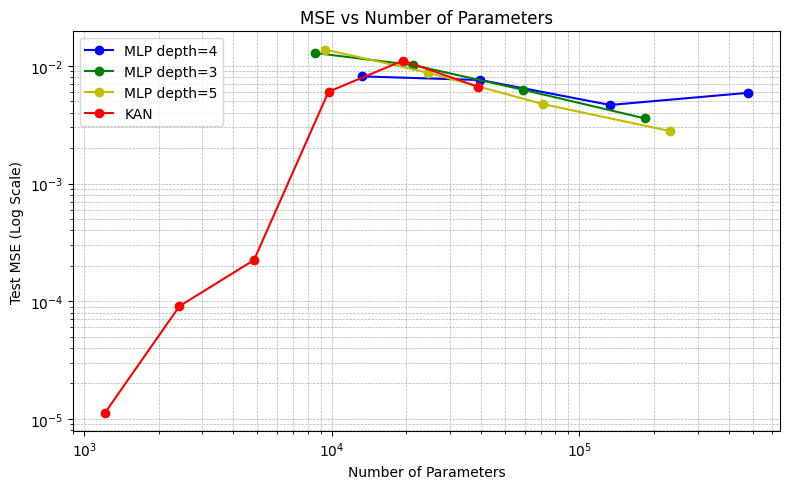

In [24]:
# === Plotting ===
plt.figure(figsize=(8, 5))
plt.plot(mlp_param_list, mlp_mse_list, 'bo-', label='MLP depth=4')
plt.plot(mlp_param_list_2, mlp_mse_list_2, 'go-', label='MLP depth=3')
plt.plot(mlp_param_list_4, mlp_mse_list_4, 'yo-', label='MLP depth=5')
plt.plot(kan_param_list, kan_mse_list, 'ro-', label='KAN')
plt.xlabel("Number of Parameters")
plt.ylabel("Test MSE (Log Scale)")
plt.title("MSE vs Number of Parameters")
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


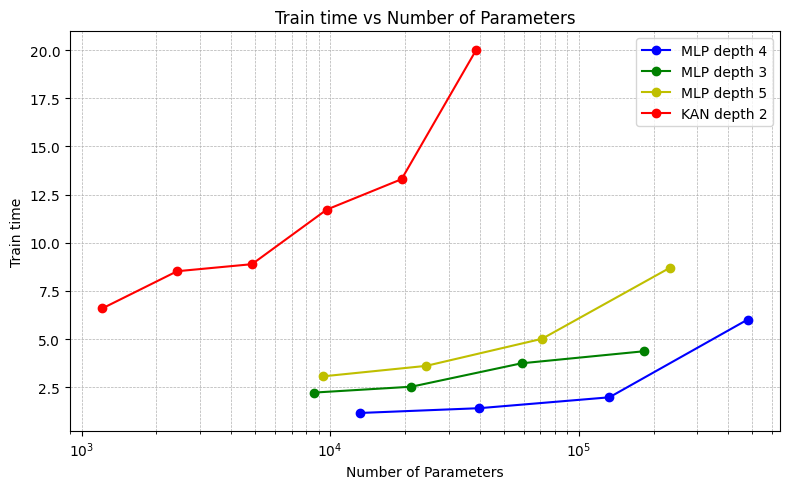

In [25]:
# === Plotting ===
plt.figure(figsize=(8, 5))
plt.plot(mlp_param_list, mlp_train_time, 'bo-', label='MLP depth 4')
plt.plot(mlp_param_list_2, mlp_train_time_2, 'go-', label='MLP depth 3')
plt.plot(mlp_param_list_4, mlp_train_time_4, 'yo-', label='MLP depth 5')
plt.plot(kan_param_list, kan_train_time, 'ro-', label='KAN depth 2')
plt.xscale("log")
plt.xlabel("Number of Parameters")
plt.ylabel("Train time")
plt.title("Train time vs Number of Parameters")
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()